In [1]:
# Run this cell to test if the LinearChain object is gonna give us a headache.
using IonSim

@time chain = LinearChain(
        ions=[Ca40([("S1/2", -1/2, "S"), ("D5/2", -1/2, "D")]), Ca40([("S1/2", -1/2, "S"), ("D5/2", -1/2, "D")])], 
        comfrequencies=(x=3e6,y=3e6,z=2.5e5), selectedmodes=(;z=[1],)
    )
chain = Nothing;

  7.862232 seconds (14.89 M allocations: 957.793 MiB, 11.82% gc time, 99.29% compilation time: <1% of which was recompilation)


In [908]:
using QuantumOptics
import PyPlot
const plt = PyPlot;
using Random, Distributions
using ProgressBars
using DelimitedFiles
Random.seed!(0)

# Locals
include("./two_ion_chamber.jl")
using .TwoIonChamber: construct_two_ion_chamber, MS, RX, RY, RZ

Some useful globals

In [909]:
########## Calcium-40 ion ##########
CALCIUM40 = Ca40([("S1/2", -1/2, "S"), ("D5/2", -1/2, "D")])

########## Some calibrated values for the Molmer-sorensen gate ##########

μ_I = 94326.65907221894 # laser-intensity, W/cm^2
μ_ν = 2.5e5 # trap-frequency, Hz
μ_f_cl = 4.111550352057269e14 # laser-frequency, Hz
μ_ϕ = 0.0 # relative phase between red and blue sidebands 
MS_π2_TIME = 1e-4 # gate-time for an MS(π/2) gate
AC_CORRECTION = 0 # ac-stark shift correction, Hz
B_STRENGTH = 6e-4 # magnetic field strength, T

########## Some useful quantum states ##########

# Computational basis
ket_00 = CALCIUM40["S"] ⊗ CALCIUM40["S"]
ket_01 = CALCIUM40["S"] ⊗ CALCIUM40["D"] # NOTE: Julia tensor product is backwards
ket_10 = CALCIUM40["D"] ⊗ CALCIUM40["S"] # NOTE: Julia tensor product is backwards
ket_11 = CALCIUM40["D"] ⊗ CALCIUM40["D"]


# Bell basis
ket_00_m_i11 = (ket_00 - 1im*ket_11)/√2
ket_00_p_i11 = (ket_00 + 1im*ket_11)/√2
ket_01_m_i10 = (ket_01 - 1im*ket_10)/√2
ket_01_p_i10 = (ket_01 + 1im*ket_10)/√2

# Motional states
chamber_temp = construct_two_ion_chamber(μ_I, μ_ν, μ_ν, μ_f_cl, μ_ϕ, MS_π2_TIME, B=B_STRENGTH, ac_correction=AC_CORRECTION);
ket_0_mot = IonSim.modes(chamber_temp)[1][0]

chamber_temp = Nothing

########## Simulation time parameters ##########

T_RANGE = 0:MS_π2_TIME*1e-3:MS_π2_TIME # time range, s
TIMESCALE = 1e-6 # integration timestep, s


1.0e-6

Helper function for plotting state populations

In [910]:
function plot_populations(tout, sol)

    # compute expectation values
    ρ_00 = dm(ket_00 ⊗ ket_0_mot)
    ρ_01 = dm(ket_01 ⊗ ket_0_mot)
    ρ_10 = dm(ket_10 ⊗ ket_0_mot)
    ρ_11 = dm(ket_11 ⊗ ket_0_mot)
    ρ_00_p_i11 = dm(ket_00_p_i11 ⊗ ket_0_mot)
    ρ_00_m_i11 = dm(ket_00_m_i11 ⊗ ket_0_mot)
    ρ_01_p_i10 = dm(ket_01_p_i10 ⊗ ket_0_mot)
    ρ_01_m_i10 = dm(ket_01_m_i10 ⊗ ket_0_mot)

    prob_00 = expect(ρ_00, sol)  # 𝔼(|S⟩|S⟩)
    prob_11 = expect(ρ_11, sol)  # 𝔼(|D⟩|D⟩)
    prob_01 = expect(ρ_01, sol)  # 𝔼(|S⟩|D⟩)
    prob_10 = expect(ρ_10, sol)  # 𝔼(|D⟩|S⟩)
    prob_00_p_i11 = expect(ρ_00_p_i11, sol)  # 𝔼(|S⟩|S⟩ + i|D⟩|D⟩)
    prob_00_m_i11 = expect(ρ_00_m_i11, sol)  # 𝔼(|S⟩|S⟩ - i|D⟩|D⟩)
    prob_01_p_i10 = expect(ρ_01_p_i10, sol)  # 𝔼(|S⟩|D⟩ + i|D⟩|S⟩)
    prob_01_m_i10 = expect(ρ_01_m_i10, sol)  # 𝔼(|S⟩|D⟩ - i|D⟩|S⟩)

    # plot results
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    ax1.plot(tout, prob_00, label="00")
    ax1.plot(tout, prob_11, label="11")
    ax1.plot(tout, prob_01, label="01")
    ax1.plot(tout, prob_10, label="10")
    ax1.set_xlim(tout[1], tout[end])
    ax1.set_ylim(0, 1)
    ax1.legend(loc=1)
    ax1.set_xlabel("Time (μs)")
    ax1.set_ylabel("Population")
    ax1.set_title("Computational basis")

    ax2.plot(tout, prob_00_p_i11, label="00 + i11")
    ax2.plot(tout, prob_00_m_i11, label="00 - i11")
    ax2.plot(tout, prob_01_p_i10, label="01 + i10")
    ax2.plot(tout, prob_01_m_i10, label="01 - i10")
    ax2.set_xlim(tout[1], tout[end])
    ax2.set_ylim(0, 1)
    ax2.legend(loc=1)
    ax2.set_xlabel("Time (μs)")
    ax2.set_ylabel("Population")
    ax2.set_title("Bell basis")

    return fig
end

plot_populations (generic function with 2 methods)

# 1. Create chamber

In [911]:
chamber = construct_two_ion_chamber(I=μ_I, ν=μ_ν, ν_target=μ_ν, f_cl=μ_f_cl, ϕ=μ_ϕ, ms_π2_time=MS_π2_TIME, B=B_STRENGTH, ac_correction=AC_CORRECTION);

# 2. Molmer-Sorensen (entangling) gate: 
 $\hat{U}_{\text{MS}}(\phi_0, \phi_1, \theta) = \begin{bmatrix} \cos\frac{\theta}{2} & 0 & 0 & -i e^{-i(\phi_0 + \phi_1)}\sin\frac{\theta}{2} \\ 0 & \cos\frac{\theta}{2} & -i e^{-i(\phi_0 - \phi_1)}\sin\frac{\theta}{2} & 0 \\ 0 &-i e^{i(\phi_0 - \phi_1)}\sin\frac{\theta}{2} & \cos\frac{\theta}{2} & 0 \\ -i e^{i(\phi_0 + \phi_1)}\sin\frac{\theta}{2} & 0 & 0 & \cos\frac{\theta}{2} \end{bmatrix}$

## 2.a. $\hat{U}_\text{MS}(0, 0, \frac{\pi}{2}) = \frac{1}{\sqrt{2}} \begin{bmatrix} 1 & 0 & 0 & i \\ 0 & 1 & i & 0 \\ 0 & i & 1 & 0 \\ i & 0 & 0 & 1\end{bmatrix} $


In [912]:
LASER1_OFFSET = 0
LASER2_OFFSET = 0

phase!(chamber.lasers[1], LASER1_OFFSET)
phase!(chamber.lasers[2], LASER2_OFFSET)

#35 (generic function with 1 method)

### 2.a.i. $\hat{U}_\text{MS}(0, 0, \frac{\pi}{2}) \ket{00} = \frac{1}{\sqrt{2}} \bigg( \ket{00} + i\ket{11} \bigg)$

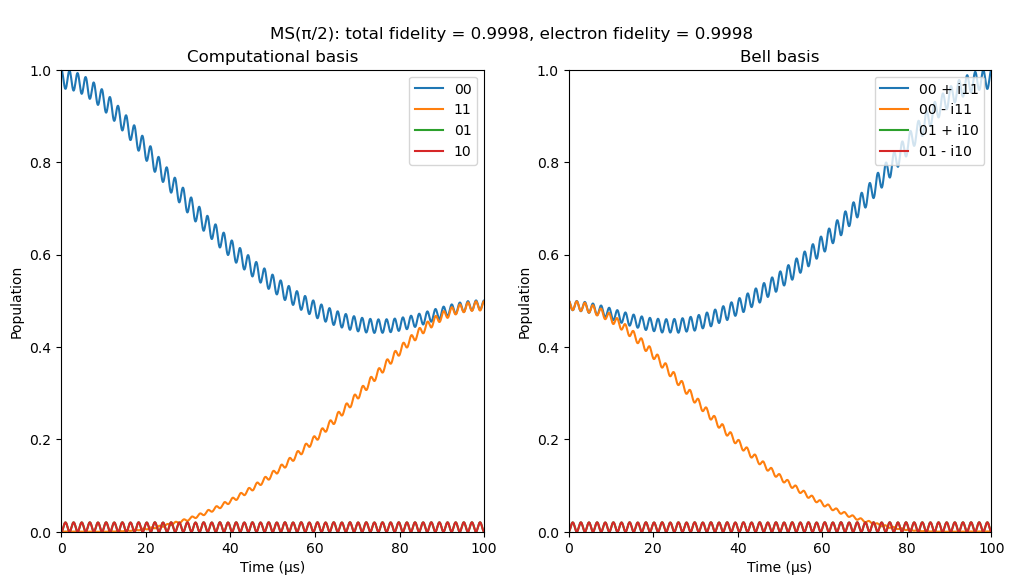

In [913]:
# Initial state
ψ0 = ket_00 ⊗ ket_0_mot

# Target state
ket_el_target = ket_00_p_i11
ρ_target = dm(ket_el_target ⊗ ket0_vib_mode)
ρ_el_target = ptrace(ρ_target, 3)

# Perform gate
tout_MS_π2, sol_MS_π2 = MS(chamber, π/2, ψ0, MS_π2_TIME, timescale=TIMESCALE)

# Evaluate performance
ρ = dm(sol_MS_π2[end])
ρ_el = ptrace(ρ, 3)
fid = round(real(fidelity(ρ, ρ_target)), digits=4)
fid_el = round(real(fidelity(ρ_el, ρ_el_target)), digits=4)
fig = plot_populations(tout_MS_π2, sol_MS_π2)
fig.suptitle("\nMS(π/2): total fidelity = $fid, electron fidelity = $fid_el")
plt.display(fig)
plt.close(fig)

### 2.a.ii. $\hat{U}_\text{MS}(0, 0, \frac{\pi}{2}) \ket{11} = \frac{1}{\sqrt{2}} \bigg( \ket{00} - i\ket{11} \bigg)$

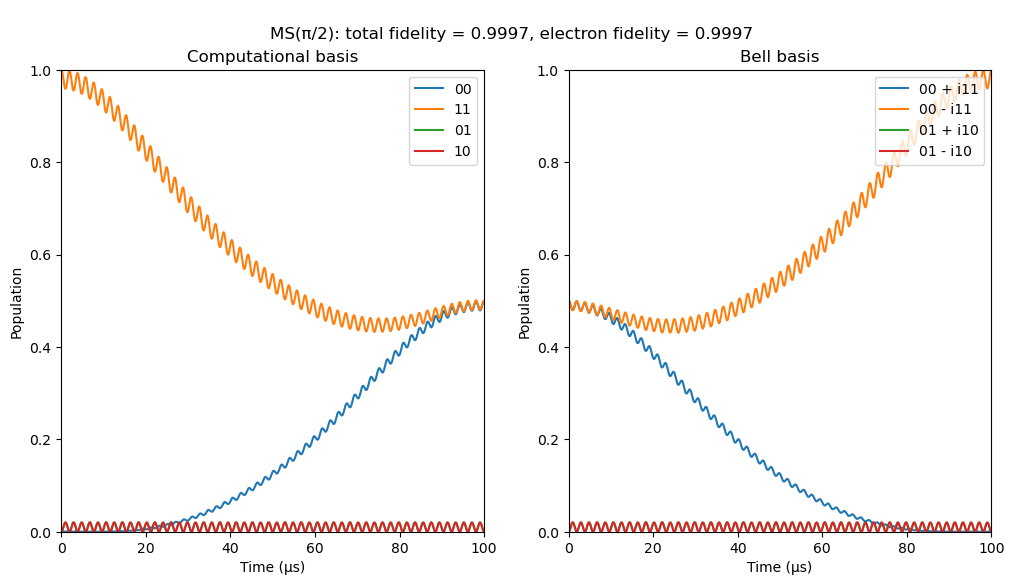

In [914]:
# Initial state
ψ0 = ket_11 ⊗ ket_0_mot

# Target state
ket_el_target = ket_00_m_i11
ρ_target = dm(ket_el_target ⊗ ket0_vib_mode)
ρ_el_target = ptrace(ρ_target, 3)

# Perform gate
tout_MS_π2, sol_MS_π2 = MS(chamber, π/2, ψ0, MS_π2_TIME, timescale=TIMESCALE)

# Evaluate performance
ρ = dm(sol_MS_π2[end])
ρ_el = ptrace(ρ, 3)
fid = round(real(fidelity(ρ, ρ_target)), digits=4)
fid_el = round(real(fidelity(ρ_el, ρ_el_target)), digits=4)
fig = plot_populations(tout_MS_π2, sol_MS_π2)
fig.suptitle("\nMS(π/2): total fidelity = $fid, electron fidelity = $fid_el")
plt.display(fig)
plt.close(fig)

### 2.a.iii. $\hat{U}_\text{MS}(0, 0, \frac{\pi}{2}) \ket{01} = \frac{1}{\sqrt{2}} \bigg( \ket{01} - i\ket{10} \bigg)$

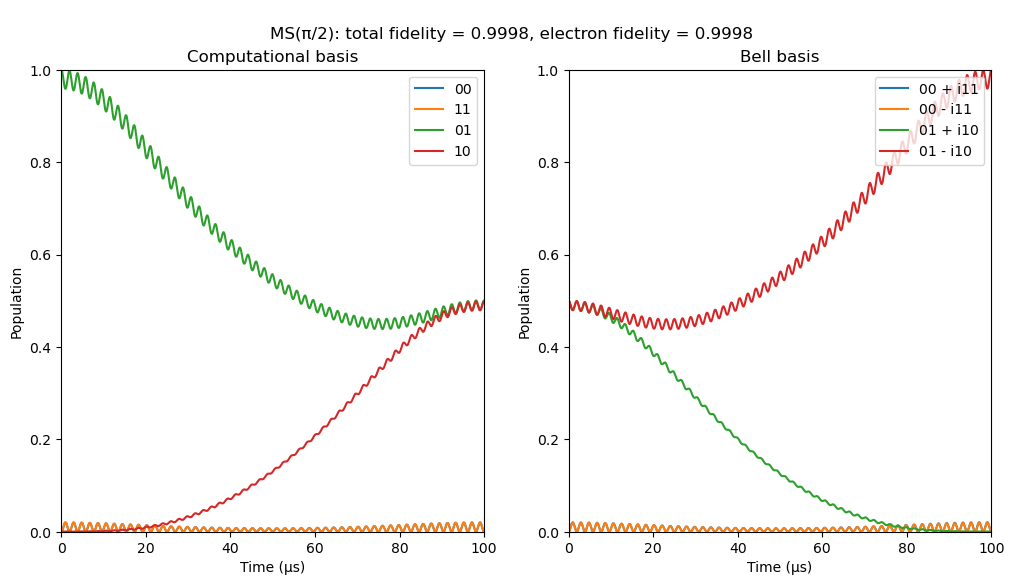

In [915]:
# Initial state
ψ0 = ket_01 ⊗ ket_0_mot

# Target state
ket_el_target = ket_01_m_i10
ρ_target = dm(ket_el_target ⊗ ket0_vib_mode)
ρ_el_target = ptrace(ρ_target, 3)

# Perform gate
tout_MS_π2, sol_MS_π2 = MS(chamber, π/2, ψ0, MS_π2_TIME, timescale=TIMESCALE)

# Evaluate performance
ρ = dm(sol_MS_π2[end])
ρ_el = ptrace(ρ, 3)
fid = round(real(fidelity(ρ, ρ_target)), digits=4)
fid_el = round(real(fidelity(ρ_el, ρ_el_target)), digits=4)
fig = plot_populations(tout_MS_π2, sol_MS_π2)
fig.suptitle("\nMS(π/2): total fidelity = $fid, electron fidelity = $fid_el")
plt.display(fig)
plt.close(fig)

### 2.a.iv. $\hat{U}_\text{MS}(0, 0, \frac{\pi}{2}) \ket{10} = \frac{1}{\sqrt{2}} \bigg( \ket{01} + i\ket{10} \bigg)$

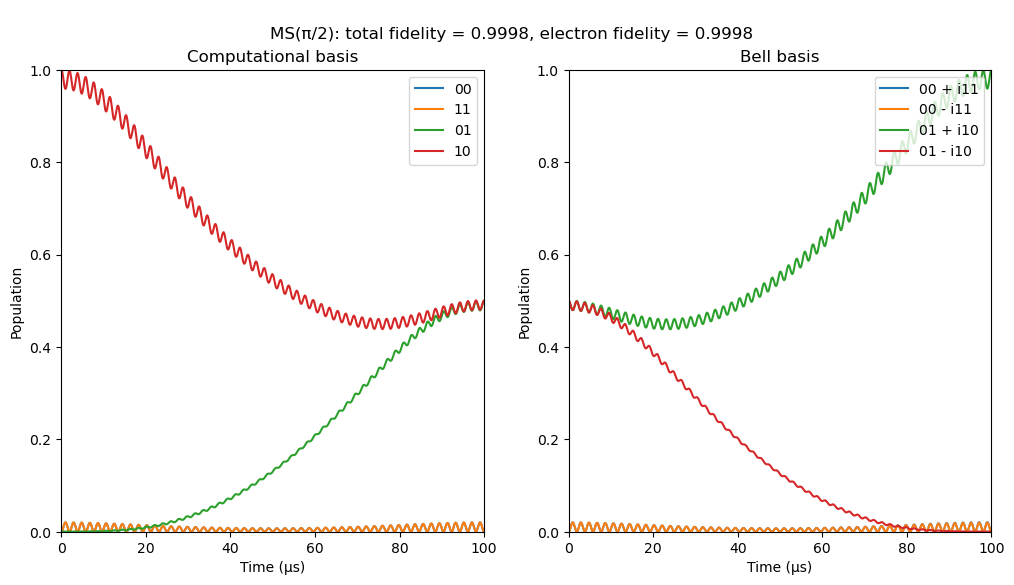

In [916]:
# Initial state
ψ0 = ket_10 ⊗ ket_0_mot

# Target state
ket_el_target = ket_01_p_i10
ρ_target = dm(ket_el_target ⊗ ket0_vib_mode)
ρ_el_target = ptrace(ρ_target, 3)

# Perform gate
tout_MS_π2, sol_MS_π2 = MS(chamber, π/2, ψ0, MS_π2_TIME, timescale=TIMESCALE)

# Evaluate performance
ρ = dm(sol_MS_π2[end])
ρ_el = ptrace(ρ, 3)
fid = round(real(fidelity(ρ, ρ_target)), digits=4)
fid_el = round(real(fidelity(ρ_el, ρ_el_target)), digits=4)
fig = plot_populations(tout_MS_π2, sol_MS_π2)
fig.suptitle("\nMS(π/2): total fidelity = $fid, electron fidelity = $fid_el")
plt.display(fig)
plt.close(fig)

# 3. Single-qubit gates: $\hat{R}_{\sigma_i}(\theta) \equiv e^{i\sigma_i\theta} = \cos \frac{\theta}{2} \hat{\mathcal{I}}  - i\sin \frac{\theta}{2} \hat{\sigma}  $


## 3.a. $\hat{R}_X(\pi/2) = \cos\frac{\pi}{4} \hat{\mathcal{I}} - i \sin\frac{\pi}{4}\hat{X}  = \frac{1}{\sqrt{2}} \begin{bmatrix} 1 & -i \\ -i & 1\end{bmatrix};$

## $\hat{R}_{X_1}(\pi/2)\ket{00} = \frac{1}{\sqrt{2}}\bigg(\ket{00} - i \ket{10} \bigg)$

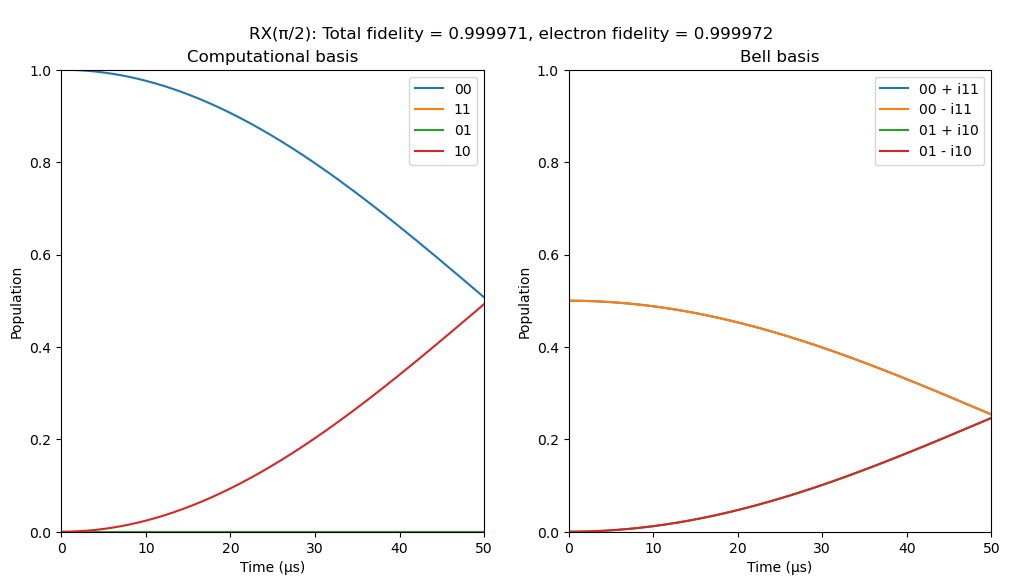

In [917]:
# Initial state 
ψ0 = ket_00 ⊗ ket_0_mot

# Target state
ket_el_target = (ket_00 - 1im*ket_10)/√2
ρ_el_target = dm(ket_el_target)
ρ_target = dm(ket_el_target ⊗ ket_0_mot)

# Perform gate
tout_RX_π, sol_RX_π = RX(chamber, 1, π/2, ψ0 , MS_π2_TIME);

# Evaluate performance
ρ = dm(sol_RX_π[end])
ρ_el = ptrace(ρ, 3)
fid = round(real(fidelity(ρ, ρ_target)), digits=6)
fid_el = round(real(fidelity(ρ_el, ρ_el_target)), digits=6)
fig = plot_populations(tout_RX_π, sol_RX_π)
fig.suptitle("\nRX(π/2): Total fidelity = $fid, electron fidelity = $fid_el")
plt.display(fig)
plt.close(fig)

## 3.b. $\hat{R}_Y(\pi/2) = \cos\frac{\pi}{4} \hat{\mathcal{I}} - i \sin\frac{\pi}{4} \hat{Y}  = \frac{1}{\sqrt{2}} \begin{bmatrix}1 & -1 \\ 1 & 1 \end{bmatrix};$

$\hat{R}_{Y_1}(\pi/2)\ket{00} = \frac{1}{\sqrt{2}}\bigg( \ket{00} + \ket{10} \bigg)$

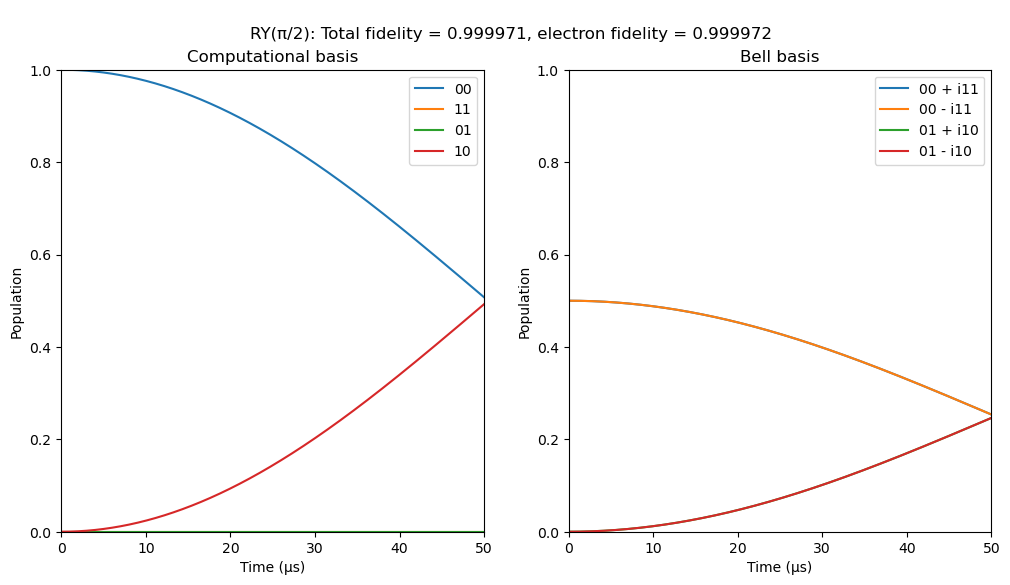

In [918]:
# Initial state 
ψ0 = ket_00 ⊗ ket_0_mot

# Target state
ket_el_target = (ket_00 + ket_10)/√2
ρ_el_target = dm(ket_el_target)
ρ_target = dm(ket_el_target ⊗ ket_0_mot)

# Perform gate
tout_RY, sol_RY = RY(chamber, 1, π/2, ψ0 , MS_π2_TIME);

# Evaluate performance
ρ = dm(sol_RY[end])
ρ_el = ptrace(ρ, 3)
fid = round(real(fidelity(ρ, ρ_target)), digits=6)
fid_el = round(real(fidelity(ρ_el, ρ_el_target)), digits=6)
fig = plot_populations(tout_RY, sol_RY)
fig.suptitle("\nRY(π/2): Total fidelity = $fid, electron fidelity = $fid_el")
plt.display(fig)
plt.close(fig)
### 1.b.iii. $\hat{R}_Z(\pi/2) = \cos\frac{\pi}{4} \hat{\mathcal{I}}  - i \sin\frac{\pi}{4} \hat{Z} = \frac{1}{\sqrt{2}} \begin{bmatrix} 1-i & 0 \\ 0 & 1+ i\end{bmatrix}$

### $\hat{R}_{Z_1}(\pi/2) \Bigg[ \frac{1}{\sqrt{2}}\bigg(\ket{00} + \ket{10}\bigg) \Bigg] = \frac{1}{\sqrt{2}}\bigg( \ket{00} - \ket{10} \bigg)$

## 3.c. $\hat{R}_Z(\pi/2) = \cos\frac{\pi}{4} \hat{\mathcal{I}} - i \sin \frac{\pi}{4} \hat{Z} = \frac{1}{\sqrt{2}} \begin{bmatrix} 1 - i & 0 \\ 0 & 1+ i \end{bmatrix}; $

$\hat{R}_{Z_1}(\pi/2) \Bigg[ \frac{1}{\sqrt{2}} \bigg( \ket{00} + \ket{10} \bigg)\Bigg] = \frac{1}{2} \Bigg[ (1-i)\ket{00} + (1+i)\ket{10}\Bigg]$

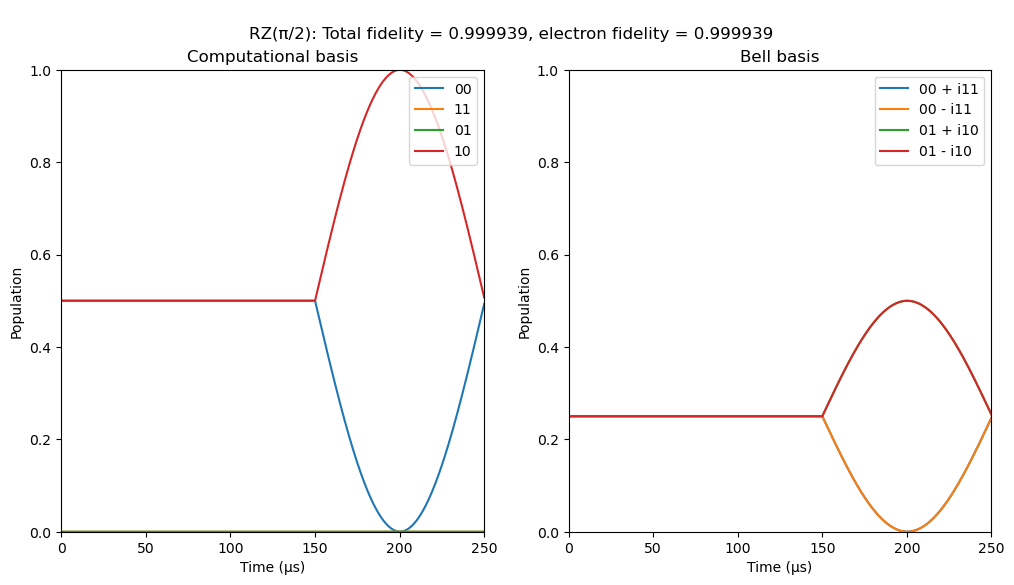

In [919]:
# Initial state 
ψ0 = ((ket_00 + ket_10)/√2) ⊗ ket_0_mot

# Target state
ket_el_target = ((1-1im)*ket_00 + (1+1im)*ket_10)/2
ρ_el_target = dm(ket_el_target)
ρ_target = dm(ket_el_target ⊗ ket_0_mot)

# Perform gate
tout_RZ, sol_RZ = RZ(chamber, 1, π/2, ψ0, MS_π2_TIME);

# Evaluate performance
ρ = dm(sol_RZ[end])
ρ_el = ptrace(ρ, 3)
fid = round(real(fidelity(ρ, ρ_target)), digits=6)
fid_el = round(real(fidelity(ρ_el, ρ_el_target)), digits=6)
fig = plot_populations(tout_RZ, sol_RZ)
fig.suptitle("\nRZ(π/2): Total fidelity = $fid, electron fidelity = $fid_el")
plt.display(fig)
plt.close(fig)